# 🌍 Examples 3D

### Notebook originally created by P.L. Vidale based on [SpeedyWeather documentation](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/examples_3D/). Minor edits by A. Denvil-Sommer.

The following showcases several examples of SpeedyWeather.jl simulating
the [Primitive equations](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/primitiveequation/) with and without
humidity and with and without physical parameterizations.

## ☝️ The primitive equations model
The [primitive equations](https://en.wikipedia.org/wiki/Primitive_equations) are a simplified version of the full compressible Navier-Stokes equations for an ideal gas on a rotating sphere. These equations form the foundation of nearly all global climate and weather models.

SpeedyWeather.jl implements the hydrostatic primitive equations, based on the idealized spectral dynamical core developed at [GFDL](https://www.gfdl.noaa.gov/) (Geophysical Fluid Dynamics Laboratory). It's documented [therein](https://www.gfdl.noaa.gov/wp-content/uploads/files/user_files/pjp/spectral_core.pdf).

The primitive equations solved by SpeedyWeather.jl for relative vorticity $\zeta$, divergence $\mathcal{D}$,
logarithm of surface pressure $\ln p_s$, temperature $T$ and specific humidity $q$ are:

$
\begin{aligned}
\frac{\partial \zeta}{\partial t} &= \nabla \times (\mathbf{\mathcal{P}}_\mathbf{u}
+ (f+\zeta)\mathbf{u}_\perp - W(\mathbf{u}) - R_dT_v\nabla \ln p_s) \\
\frac{\partial \mathcal{D}}{\partial t} &= \nabla \cdot (\mathcal{P}_\mathbf{u}
+ (f+\zeta)\mathbf{u}_\perp - W(\mathbf{u}) - R_dT_v\nabla \ln p_s) - \nabla^2(\frac{1}{2}(u^2 + v^2) + \Phi) \\
\frac{\partial \ln p_s}{\partial t} &= -\frac{1}{p_s} \nabla \cdot \int_0^{p_s} \mathbf{u}~dp \\
\frac{\partial T}{\partial t} &= \mathcal{P}_T -\nabla\cdot(\mathbf{u}T) + T\mathcal{D} - W(T) + \kappa T_v \frac{D \ln p}{Dt} \\
\frac{\partial q}{\partial t} &= \mathcal{P}_q -\nabla\cdot(\mathbf{u}q) + q\mathcal{D} - W(q)\\
\end{aligned}
$

🧩 This setup closely mirrors the dynamical cores used in real climate models, such as those in the Met Office’s Unified Model or ECMWF’s IFS, though with simplified physics and resolution to allow fast, interactive experim

The full description, including variable definitions and the solution algorithm is available here: [Primitive Equations in SpeedyWeather](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/primitiveequation/)

See also [Examples 2D](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/examples_2D/) for examples with the
[Barotropic vorticity equation](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/examples_2D/#2D-turbulence-on-a-non-rotating-sphere) and the
[shallow water model](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/examples_2D/#Shallow-water-with-mountains).

# 🌊🌪️ Jablonowski-Williamson baroclinic wave
Please note that, now that we have 8 layers and more equations to solve, while T63 truncation looks very attractive, you will find that it runs too slowly on many of the older PCs. For initial testing, **we strongly recommend that you start at T31 truncation**. You can always come back and re-run at T63, or even T127, when you are fully satisfied with your development(s).

In [1]:
using SpeedyWeather
spectral_grid = SpectralGrid(trunc=63, nlayers=8, Grid=FullGaussianGrid, dealiasing=3)

orography = ZonalRidge(spectral_grid)
initial_conditions = InitialConditions(
    vordiv = ZonalWind(),
    temp = JablonowskiTemperature(),
    pres = ZeroInitially())

model = PrimitiveDryModel(spectral_grid; orography, initial_conditions, physics=false)
simulation = initialize!(model)
run!(simulation, period=Day(9))

Weather is speedy: 100%|██████████████████| Time: 0:00:10 (204.42 years/day)


Simulation{PrimitiveDryModel}
├ prognostic_variables::PrognosticVariables{...}
├ diagnostic_variables::DiagnosticVariables{...}
└ model::PrimitiveDryModel{...}

📌 The Jablonowski–Williamson baroclinic wave test case [JW06](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/examples_3D/#Jablonowski-Williamson-baroclinic-wave) is a standard benchmark for evaluating the performance of a dynamical core. In this example, we use the [Primitive Equation Model](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/primitiveequation/), specifically the dry version, with all physics turned off (`physics=false`).

We use 8 vertical levels, and while a spectral truncation of T63 is commonly used, it is often advisable to start with T31 on a [Full Gaussian Grid](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/grids/#FullGaussianGrid) for a more manageable resolution.

Initial conditions include:

- `ZonalWind` for vorticity and divergence (computed from the curl and divergence of the wind field)

- `JablonowskiTemperature` for the temperature field

- `ZeroInitially` for the surface pressure

- `ZonalRidge` for orography

No external forcing is applied. The system is baroclinically unstable, meaning that the initial state is designed to naturally develop an eastward-propagating wave. This growing wave structure becomes clearly visible when visualised over time.

In [2]:
using CairoMakie
vor = simulation.diagnostic_variables.grid.vor_grid[:, end]
fig=heatmap(vor, title="Surface relative vorticity")
save("jablonowski.png", fig)

<img src="jablonowski.png" width="100%">

### 🧩🌀 Challenge on the J-W baroclinic instability problem
Use the example from the first notebook (GIWs and Equatorially traped waves) to save output to NetCDF, then create a sequence of PNG files, and animate. Produce an mp4 file that can be shown to your colleagues.

🧠 Question: what can you learn about the physics of this problem by watching the evolution of the flow in time?

*Exercise:* now insert Earth's orography and re-run the problem.

🧠 Questions:
- How does orography modify the evolution of the flow?
- Can you see any difference in the vorticity field?
- What happens in the Southern Hemisphere, and why?

## 🌀 Held-Suarez forcing

In [3]:
#using SpeedyWeather
#spectral_grid = SpectralGrid(trunc=63, nlayers=8)
spectral_grid = SpectralGrid(trunc=511, nlayers=8)
output = NetCDFOutput(spectral_grid, PrimitiveDryModel, id="Held-Suarez", output_dt=Minute(60))
add!(output, SpeedyWeather.TemperatureOutput())  # output also temperature

# construct model with only Held-Suarez forcing, no other physics
model = PrimitiveDryModel(
    spectral_grid,

    # Held-Suarez forcing and drag
    temperature_relaxation = HeldSuarez(spectral_grid),
    boundary_layer_drag = LinearDrag(spectral_grid),

    # switch off other physics
    convection = NoConvection(),
    shortwave_radiation = NoShortwave(),
    longwave_radiation = NoLongwave(),
    vertical_diffusion = NoVerticalDiffusion(),

    # switch off surface fluxes (makes ocean/land/land-sea mask redundant)
    surface_wind = NoSurfaceWind(),
    surface_heat_flux = NoSurfaceHeatFlux(),

    # use Earth's orography
    orography = EarthOrography(spectral_grid),
    output=output
)

simulation = initialize!(model)
run!(simulation, period=Day(1),output=true)
nothing # hide

Weather is speedy: run Held-Suarez 100%|██| Time: 0:25:53 (55.54 days/day)


📌 The code above sets up Held–Suarez forcing [HS94](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/examples_3D/#Held-Suarez-forcing) in the primitive dry model by including:

- A temperature relaxation term that nudges temperatures toward an idealized equilibrium.

- A linear drag applied near the surface (planetary boundary layer).

All other physical processes are switched off.

Since the model does not include humidity, turning off surface wind also effectively disables:

- Evaporation (not relevant in the _dry_ model)

- Sensible heat flux, which depends on surface wind speed

To fully skip unnecessary calculations, we explicitly set: `NoSurfaceHeatFlux()`.

Many `NoSomething()` components don’t strictly require the spectral_grid, but SpeedyWeather allows it to be passed for consistency across component definitions.

Visualising surface temperature with this:

In [4]:
using CairoMakie
temp = simulation.diagnostic_variables.grid.temp_grid[:, end]
#temp = simulation.diagnostic_variables.grid.temp_grid[:, 1]
fig=heatmap(temp, title="Surface temperature [K]", colormap=:thermal)
save("heldsuarez.png", fig) # hide
nothing # hide

In [5]:
temp

603648-element, 768-ring OctahedralGaussianField{Float32, 1} on Array on SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}:
 224.07004
 224.07193
 224.07631
 224.08255
 224.08952
 224.09612
 224.10147
 224.10495
 224.10643
 224.10617
 224.10464
 224.10217
 224.09871
   ⋮
 223.05501
 222.97563
 222.88179
 222.77962
 222.6765
 222.58281
 222.51242
 222.47987
 222.49464
 222.5565
 222.65501
 222.77333

In [17]:
using NCDatasets
ds = NCDataset("run_Held-Suarez/output.nc")
#ds["vor"]
ds["temp"]

temp (1536 × 768 × 8 × 25)
  Datatype:    Union{Missing, Float32} (Float32)
  Dimensions:  lon × lat × layer × time
  Attributes:
   units                = degC
   long_name            = temperature
   _FillValue           = NaN


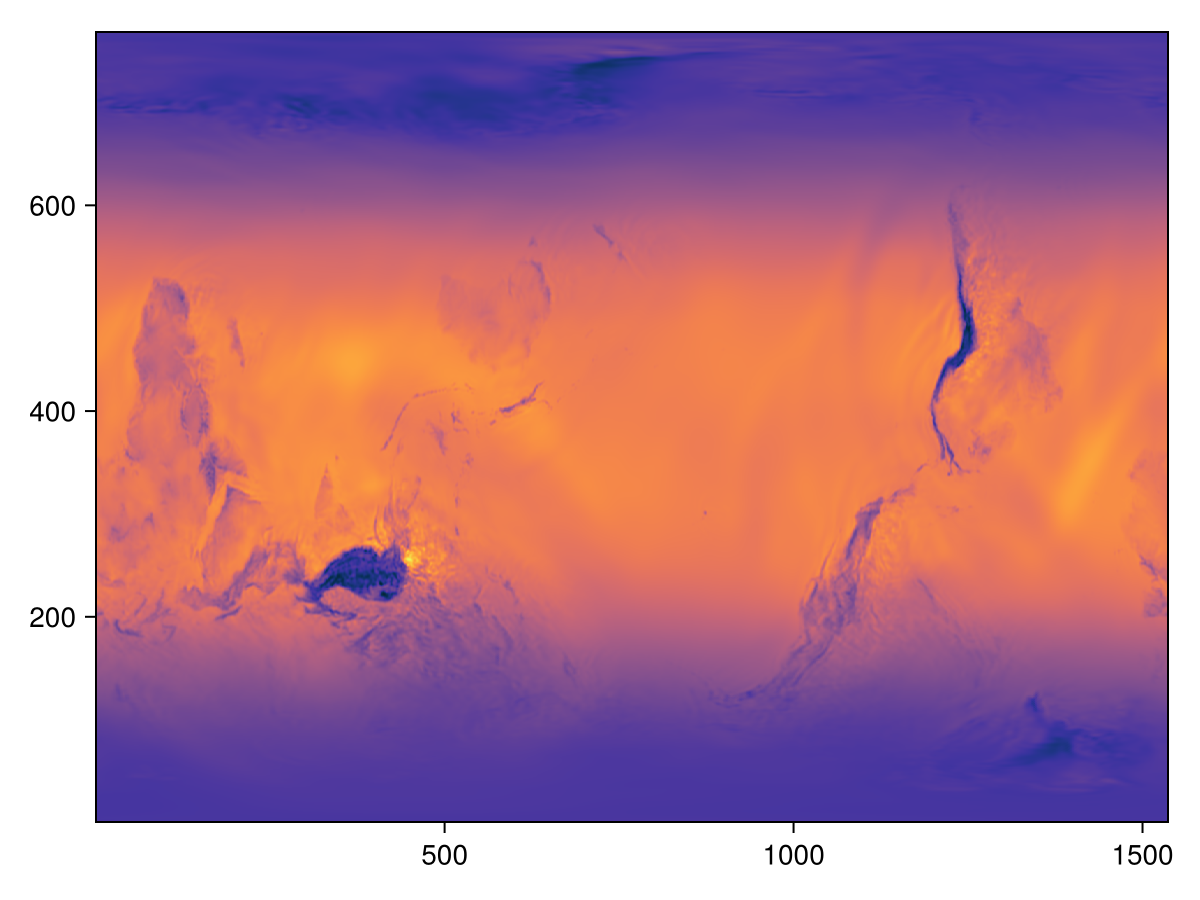

In [18]:
temptemp=ds["temp"]
temptemp
using CairoMakie
heatmap(temptemp[:,:, 4, end], colormap=:thermal)

In [19]:
temp = FullGaussianGrid(ds["temp"].var[:, :, :, :], input_as=Matrix)
temp

1179648×8×25, 768-ring FullGaussianField{Float32, 3} on Array on SpeedyWeather.Architectures.CPU{KernelAbstractions.CPU}:
[:, :, 1] =
 -71.125  -45.5312  -33.625  -32.0312  -36.4688  -43.25  -48.75  -49.3125
 -71.125  -45.5312  -33.625  -32.0312  -36.4688  -43.25  -48.75  -49.3125
 -71.125  -45.5312  -33.625  -32.0312  -36.4688  -43.25  -48.75  -49.3125
 -71.125  -45.5312  -33.625  -32.0312  -36.4688  -43.25  -48.75  -49.3125
 -71.125  -45.5312  -33.625  -32.0312  -36.4688  -43.25  -48.75  -49.3125
 -71.125  -45.5312  -33.625  -32.0312  -36.4688  -43.25  -48.75  -49.3125
 -71.125  -45.5312  -33.625  -32.0312  -36.4688  -43.25  -48.75  -49.3125
 -71.125  -45.5312  -33.625  -32.0312  -36.4688  -43.25  -48.75  -49.3125
 -71.125  -45.5312  -33.625  -32.0312  -36.4688  -43.25  -48.75  -49.3125
 -71.125  -45.5312  -33.625  -32.0312  -36.4688  -43.25  -48.75  -49.3125
 -71.125  -45.5312  -33.625  -32.0312  -36.4688  -43.25  -48.75  -49.3125
 -71.125  -45.5312  -33.625  -32.0312  -36.4688  -43

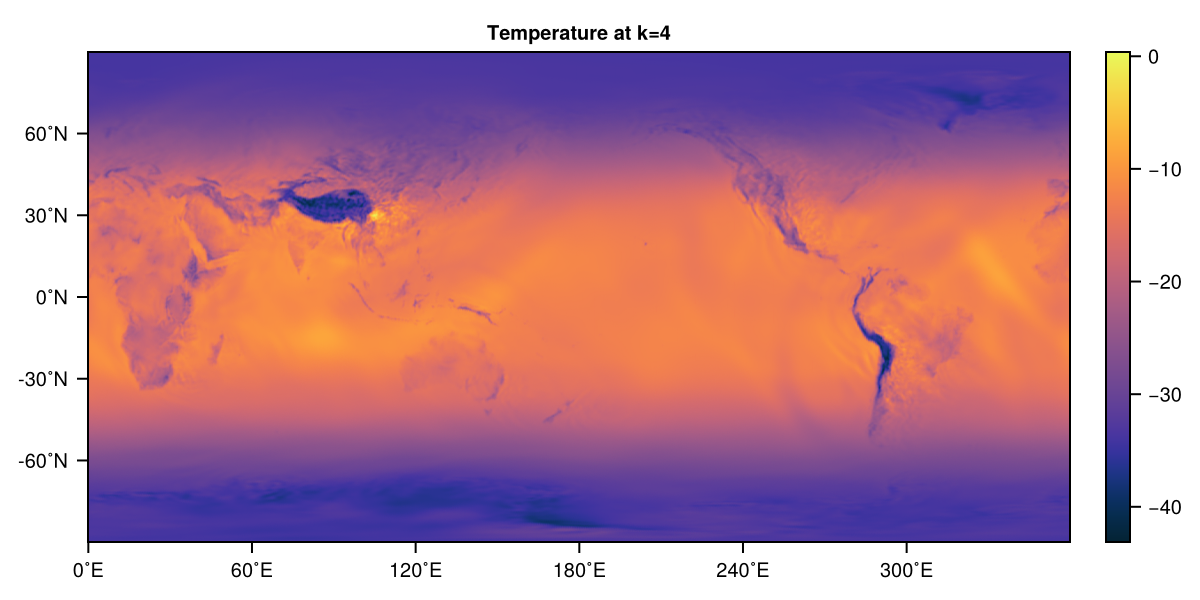

In [20]:
temp = FullGaussianGrid(ds["temp"].var[:, :, :, :], input_as=Matrix)
temp
using CairoMakie
heatmap(temp[:, 4, end], title="Temperature at k=4", colormap=:thermal)

<img src="heldsuarez.png" width="100%">

### 🧩🌀 Challenge on the Held-Suarez problem
Once again, save the output to NetCDF, then create a sequence of PNG files, and animate. Produce an mp4 file that can be shown to your colleagues.

🧠 Questions: 
- what is this test of the dynamical core designed to do?
- how is that objective achieved?
- what can you learn about the physics of this problem by watching the evolution of the flow in time?

## 🌎💧 Aquaplanet

📌 The Aquaplanet setup is a common next step for weather and climate modellers when testing a new dynamical core.

It removes the complexity of land–sea contrasts and surface parametrisations, offering a pure testbed for atmospheric fluid dynamics.
With a uniform ocean surface and idealized physics, it's easier to isolate and understand:

- How the model handles large-scale circulation

- The behavior of tropical convection and jet streams

- The emergence of baroclinic instabilities and equatorial waves

By focusing on a simplified configuration, modellers can more clearly evaluate the stability, realism, and biases of their numerical schemes.

In [21]:
using SpeedyWeather

# components
spectral_grid = SpectralGrid(trunc=63, nlayers=8)
ocean = AquaPlanet(spectral_grid, temp_equator=302, temp_poles=273)
land_sea_mask = AquaPlanetMask(spectral_grid)
orography = NoOrography(spectral_grid)

# create model, initialize, run
model = PrimitiveWetModel(spectral_grid; ocean, land_sea_mask, orography)
simulation = initialize!(model)
run!(simulation, period=Day(50))
nothing # hide

Weather is speedy: 100%|██████████████████| Time: 0:01:25 (139.04 years/day)


In this experiment, we define an aquaplanet simulation, meaning a planet fully covered by ocean, to simplify the study of atmospheric dynamics and convection.

Here's how we set it up:

- `ocean = AquaPlanet()`: Sets sea surface temperature (SST) as a smooth function of latitude — constant zonally, no land/ocean temperature contrast.

- `land_sea_mask = AquaPlanetMask()`: Defines all grid points as ocean (`false = ocean`), so no land interaction occurs.

- `orography = NoOrography()`: Removes terrain elevation, setting the surface geopotential to zero.

These are passed to a `PrimitiveWetModel`, which includes moisture and default physics parameterizations (like radiation and convection).

📝 Note: You could also modify the land and vegetation components, but since the mask treats the surface as ocean-only, these have no effect on the simulation.

⚠️ Important detail:
While SST, land-sea mask, and orography can technically be defined independently, mismatches can lead to unrealistic situations (e.g. ocean over mountains). The land-sea mask controls whether fluxes from a grid cell are considered — partially masked grid cells may have their surface fluxes reduced or nullified depending on the land temperature.

💧 Surface Humidity After 50 Days
After running the model for 50 days, we visualize surface humidity.
It takes longer for instabilities to grow in this setup (no orographic triggers), but eventually, convection develops — leading to:

- Small-scale humidity patches, especially in the tropics

- Evidence of updrafts and downdrafts from the convection scheme

This gives insight into how the model handles moist processes in a simplified but dynamically active environment.

In [22]:
#using CairoMakie
humid = simulation.diagnostic_variables.grid.humid_grid[:, end]
fig=heatmap(humid, title="Surface specific humidity [kg/kg]", colormap=:oslo)
save("aquaplanet.png", fig) # hide
nothing # hide

<img src="aquaplanet.png" width="100%">

## 🌎🚫💦 Aquaplanet without (deep) convection
Now let’s compare our previous aquaplanet simulation with one where deep convection is disabled.

We use the `DryBettsMiller` convection scheme — a modified version of [Betts–Miller convection](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/convection/#BettsMiller) — but with humidity set to zero. This makes the convection non-precipitating and shallow, since there's no latent heat release from condensation to drive deeper updrafts.

💡 This type of convection is the default when using the `PrimitiveDryModel`.

Instead of redefining everything from scratch, we reuse the components from the previous setup:

- `spectral_grid`

- `ocean`

- `land_sea_mask`

- `orography`

Because we haven’t changed the grid (`spectral_grid`), we can safely plug in the same components and just switch the model type and physics scheme.

In [23]:
# Execute the code from Aquaplanet above first!
convection = DryBettsMiller(spectral_grid, time_scale=Hour(4))

# reuse other model components from before
model = PrimitiveWetModel(spectral_grid; ocean, land_sea_mask, orography, convection)

simulation = initialize!(model)
run!(simulation, period=Day(50))

humid = simulation.diagnostic_variables.grid.humid_grid[:, end]
fig=heatmap(humid, title="No deep convection: Surface specific humidity [kg/kg]", colormap=:oslo)
save("aquaplanet_nodeepconvection.png", fig) # hide
nothing # hide

Weather is speedy: 100%|██████████████████| Time: 0:01:11 (165.04 years/day)


<img src="aquaplanet_nodeepconvection.png" width="100%">

We also want to compare this to a setup where convection is completely turned off, by setting: `convection = NoConvection()`.
🚫 This disables all convective processes.
📌 Note: Many `NoComponent()` types in SpeedyWeather don’t require the `spectral_grid`, but some still do — so always check the documentation or error messages when setting them up.

In [24]:
# Execute the code from Aquaplanet above first!
convection = NoConvection(spectral_grid)

# reuse other model components from before
model = PrimitiveWetModel(spectral_grid; ocean, land_sea_mask, orography, convection)

simulation = initialize!(model)
run!(simulation, period=Day(50))

humid = simulation.diagnostic_variables.grid.humid_grid[:, end]
fig=heatmap(humid, title="No convection: Surface specific humidity [kg/kg]", colormap=:oslo)
save("aquaplanet_noconvection.png", fig) # hide
nothing # hide

Weather is speedy: 100%|██████████████████| Time: 0:01:11 (164.89 years/day)


And the comparison looks like

<img src="aquaplanet_nodeepconvection.png" width="100%">
<img src="aquaplanet_noconvection.png" width="100%">


## 🌧️⚖️ Large-scale vs convective precipitation

In [25]:
using SpeedyWeather

# components
spectral_grid = SpectralGrid(trunc=31, nlayers=8)
large_scale_condensation = ImplicitCondensation(spectral_grid)
convection = SimplifiedBettsMiller(spectral_grid)

# create model, initialize, run
model = PrimitiveWetModel(spectral_grid; large_scale_condensation, convection)
simulation = initialize!(model)
run!(simulation, period=Day(10))
nothing # hide

Weather is speedy: 100%|██████████████████| Time: 0:00:01 (1390.49 years/day)


In this experiment, we run the default `PrimitiveWetModel`, which includes:

- `ImplicitCondensation` to handle large-scale precipitation, triggered when relative humidity reaches 100%
(see: [Implicit large-scale condensation](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/large_scale_condensation/#Implicit-large-scale-condensation))

- `SimplifiedBettsMiller` for convective precipitation, representing fast, localized rain events from convection
(see: [Simplified Betts–Miller](https://speedyweather.github.io/SpeedyWeatherDocumentation/dev/convection/#BettsMiller))

💡 These schemes come with several tunable parameters, but we’ll keep them at default for now.
For example, you could modify the relative humidity threshold like this: `ImplicitCondensation(spectral_grid, relative_humidity_threshold = 0.8)`

This would cause precipitation to begin at 80% relative humidity instead of 100%.

Now, we’ll analyze the precipitation fields produced by these two processes — to see how much rain comes from each and where.

In [26]:
using CairoMakie

(; precip_large_scale, precip_convection) = simulation.diagnostic_variables.physics
m2mm = 1000     # convert from [m] to [mm]
fig=heatmap(m2mm*precip_large_scale, title="Large-scale precipiation [mm]: Accumulated over 10 days", colormap=:dense)
save("large-scale_precipitation_acc.png", fig) # hide
nothing # hide

<img src="large-scale_precipitation_acc.png" width="100%">

Precipitation (both large-scale and convective) are written into the
`simulation.diagnostic_variables.physics` which, however, accumulate all precipitation
during simulation. In the NetCDF output, precipitation rate (in mm/hr) is calculated
from accumulated precipitation as a post-processing step.
More interactively, you can also reset these accumulators and integrate for another 6 hours
to get the precipitation only in that period.

In [27]:
# reset accumulators and simulate 6 hours
simulation.diagnostic_variables.physics.precip_large_scale .= 0
simulation.diagnostic_variables.physics.precip_convection .= 0
run!(simulation, period=Hour(6))

# visualise, precip_* arrays are flat copies, no need to read them out again!
m2mm_hr = (1000*Hour(1)/Hour(6))    # convert from [m] to [mm/hr]
fig=heatmap(m2mm_hr*precip_large_scale, title="Large-scale precipiation [mm/hr]", colormap=:dense)
save("large-scale_precipitation.png", fig) # hide
fig2=heatmap(m2mm_hr*precip_convection, title="Convective precipiation [mm/hr]", colormap=:dense)
save("convective_precipitation.png", fig2) # hide
nothing # hide


As the precipitation fields are accumulated meters over the integration period
we divide by 6 hours to get a precipitation rate ``[m/s]``
but then multiply with 1 hour and 1000 to get the typical precipitation unit of ``[mm/hr]``.

<img src="large-scale_precipitation_acc.png" width="100%">

<img src="convective_precipitation.png" width="100%">

## References

Jablonowski, C. and Williamson, D.L. (2006), A baroclinic instability test case for atmospheric model dynamical cores. Q.J.R. Meteorol. Soc., 132: 2943-2975. DOI:[10.1256/qj.06.12](https://doi.org/10.1256/qj.06.12)

Held, I. M. & Suarez, M. J. A Proposal for the Intercomparison of the Dynamical Cores of Atmospheric General Circulation Models. Bulletin of the American Meteorological Society 75, 1825-1830 (1994). DOI:[10.1175/1520-0477(1994)075<1825:APFTIO>2.0.CO;2](10.1175/1520-0477(1994)075<1825:APFTIO>2.0.CO;2)